In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

from subprocess import check_output

In [2]:
df = pd.read_csv('Sentiment.csv')
df = df[['text','sentiment']]

In [3]:
train,test = train_test_split(df,test_size=0.1)

train = train[train.sentiment !='Neutral']

Positive words


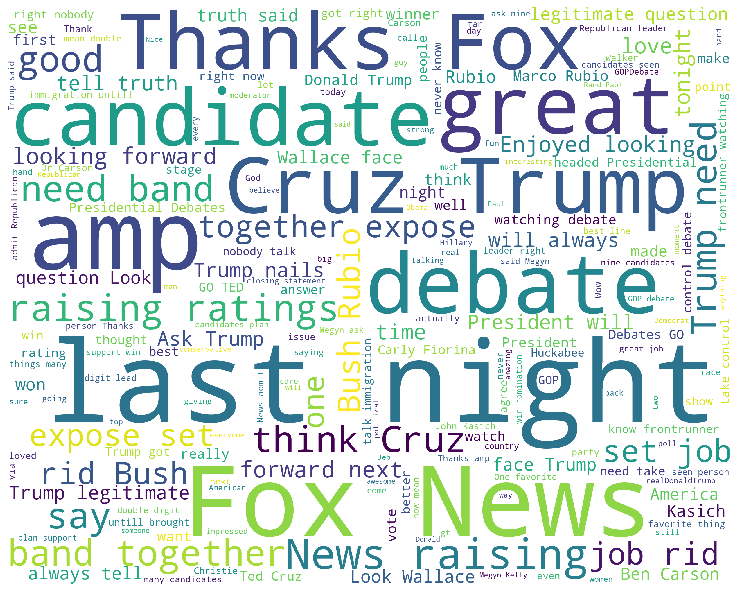

Negative words


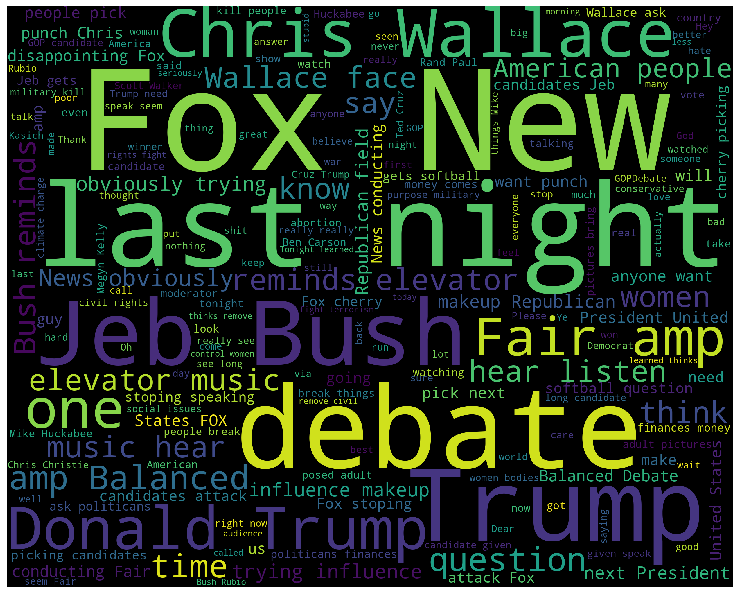

In [4]:
train_pos = train[train['sentiment']=='Positive']
train_pos = train_pos['text']

train_neg = train[train['sentiment']=='Negative']
train_neg = train_neg['text']

def wordcloud_draw(data,color ='black'):
    words = ' '.join(data)
    cleaned_data = " ".join([word for word in words.split() 
                             if 'http' not in word 
                             and not word.startswith('@')
                             and not word.startswith('#')
                             and word !='RT'
                             ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_data)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    

print("Positive words")
wordcloud_draw(train_pos,'white')
print("Negative words")
wordcloud_draw(train_neg)

Interesting to notice the following words and expressions in the positive word set:
 **truth**, **strong**, **legitimate**,  **together**, **love**, **job**

In my interpretation, people tend to believe that their ideal candidate is truthful, legitimate, above good and bad.


----------


At the same time, negative tweets contains words like:
**influence**, **news**, **elevator music**, **disappointing**, **softball**, **makeup**, **cherry picking**, **trying**

In my understanding people missed the decisively acting and considered the scolded candidates too soft and cherry picking. 

In [5]:
tweets = []
stopwords_set = set(stopwords.words("english"))

In [6]:
for index,row in train.iterrows():
    word_filtered = [e.lower() for e in row.text.split() if len(e)>=3]
    words_cleaned = [word for word in word_filtered 
                     if 'http' not in word
                     and not word.startswith('@')
                     and not word.startswith('#')
                     and word != 'RT']
    words_without_stopwords = [word for word in words_cleaned if word not in stopwords_set]
    tweets.append((words_without_stopwords,row.sentiment))
    
test_pos = test[ test['sentiment'] == 'Positive']
test_pos = test_pos['text']
test_neg = test[ test['sentiment'] == 'Negative']
test_neg = test_neg['text']    

In [7]:
def get_words_in_tweets(tweets):
    all =[]
    for (words,sentiment) in tweets:
        all.extend(words)
    return all

def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    features = wordlist.keys()
    return features

w_features = get_word_features(get_words_in_tweets(tweets))

def extract_features(document):
    document_words = set(document)
    features = {}
    for word in w_features:
        features['contains(%s)' % word] = (word in document_words)   
    return features    

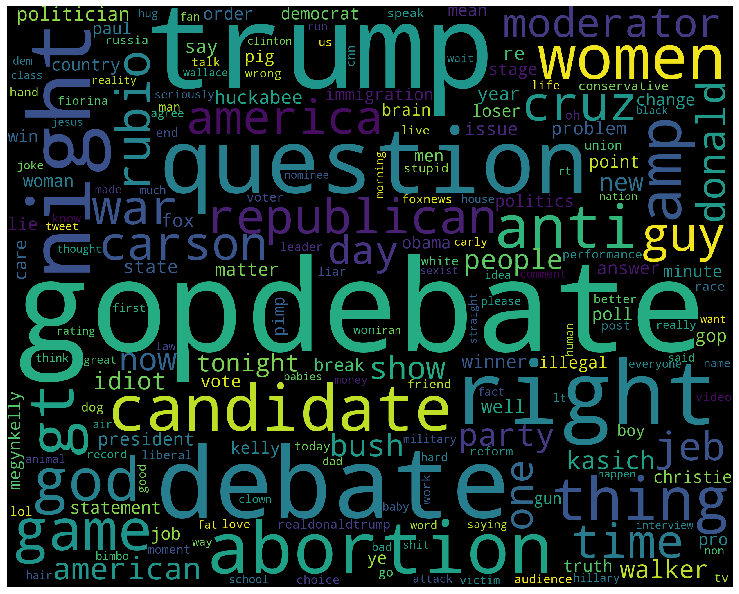

In [8]:
wordcloud_draw(w_features)

In [9]:
# Training the Naive Bayes classifier
training_set = nltk.classify.apply_features(extract_features,tweets)
classifier = nltk.NaiveBayesClassifier.train(training_set)

In [10]:

neg_cnt = 0
pos_cnt = 0
for obj in test_neg: 
    res =  classifier.classify(extract_features(obj.split()))
    if(res == 'Negative'): 
        neg_cnt = neg_cnt + 1
for obj in test_pos: 
    res =  classifier.classify(extract_features(obj.split()))
    if(res == 'Positive'): 
        pos_cnt = pos_cnt + 1
        
print('[Negative]: %s/%s '  % (len(test_neg),neg_cnt))        
print('[Positive]: %s/%s '  % (len(test_pos),pos_cnt))    

[Negative]: 833/790 
[Positive]: 207/85 


## Epilog ##

In this project I was curious how well nltk and the NaiveBayes Machine Learning algorithm performs for Sentiment Analysis. In my experience, it works rather well for negative comments. The problems arise when the tweets are ironic, sarcastic has reference or own difficult context.

Consider the following tweet:
*"Muhaha, how sad that the Liberals couldn't destroy Trump.  Marching forward."*
As you may already thought, the words **sad** and **destroy** highly influences the evaluation, although this tweet should be positive when observing its meaning and context. 